In [1]:
import os
import gc
import sys
import joblib
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime
from argparse import Namespace
from collections import defaultdict
from scipy.signal import find_peaks

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GroupKFold, train_test_split, KFold

import lightgbm as lgb
from lightgbm import LGBMRegressor

import matplotlib.style as style
style.use('fivethirtyeight') 

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 64

def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2]:
args = Namespace(
    train=True,
    optimize=False,
    train_l2=False,
    inference=False,
    seed=21,
    folds=5,
    workers=4,
    min_time_id=None, 
    holdout=False,
    cv_method="single",
    num_bins=16,
    holdout_size=100,
    outlier_threshold=0.001,
    trading_days_per_year=250,   # chinese stock market trading days per year (roughly)
    add_investment_id_model=False,
    data_path=Path(""),
    just_eda=True,
)
seed_everything(args.seed)

assert args.cv_method in {"single", "kfold", "group", "stratified", "time", "group_time", "time_range"}, "unknown cv method"
assert args.data_path.exists(), "data_path not exists"

In [3]:
%%time
train = pd.read_parquet(args.data_path.joinpath("train_low_mem.parquet"))
# assert train.isnull().any().sum() == 0, "null exists."
# assert train.row_id.str.extract(r"(?P<time_id>\d+)_(?P<investment_id>\d+)").astype(train.time_id.dtype).equals(train[["time_id", "investment_id"]]), "row_id!=time_id_investment_id"
# assert train.time_id.is_monotonic_increasing, "time_id not monotonic increasing"

CPU times: user 2.35 s, sys: 737 ms, total: 3.09 s
Wall time: 3.09 s


# Features EDA + processing

### Possible outliers

0.1947705768049055

-0.3884331084489822

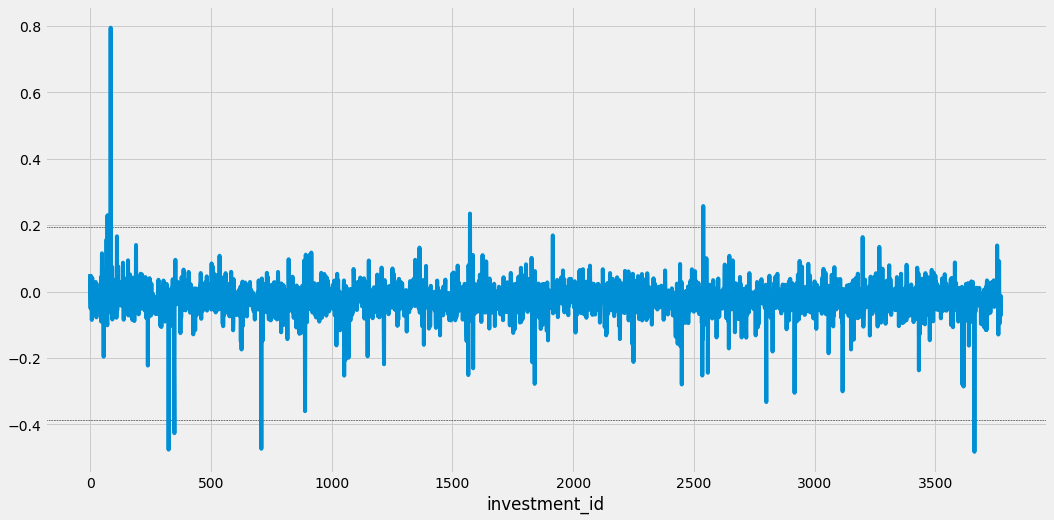

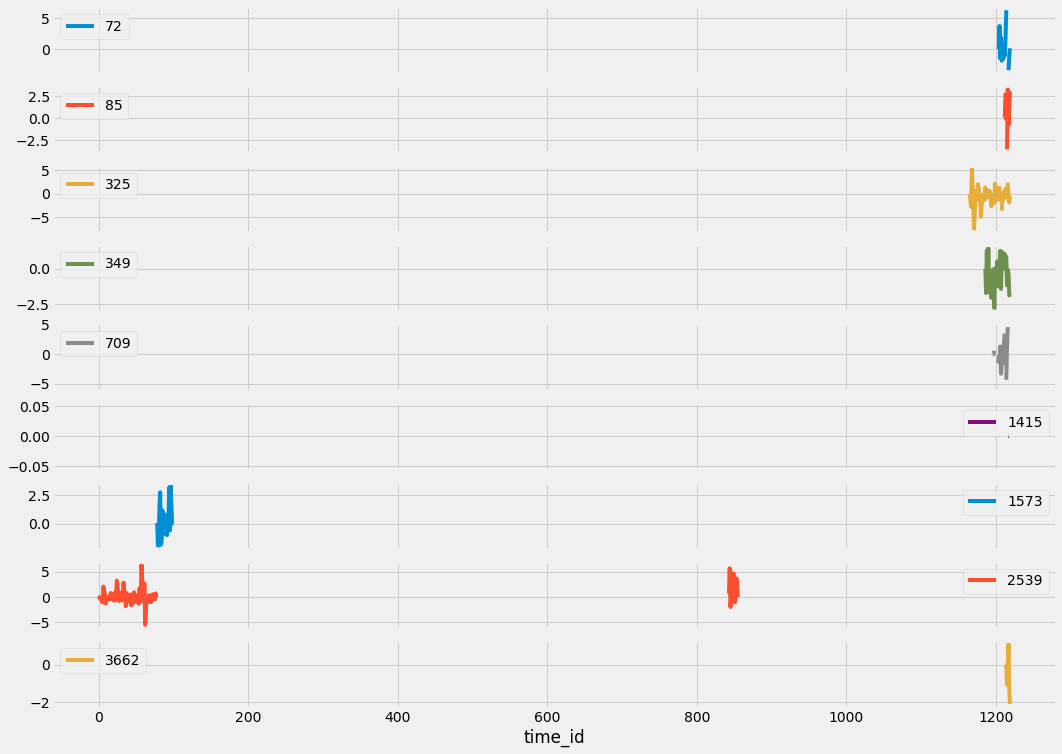

In [4]:
df = train[["investment_id", "target"]].groupby("investment_id").target.mean()
upper_bound, lower_bound = df.quantile([1-args.outlier_threshold, args.outlier_threshold])
display(upper_bound, lower_bound)
ax = df.plot(figsize=(16, 8))
ax.axhspan(lower_bound, upper_bound, fill=False, linestyle="--", color="k")
plt.show()

outlier_investments = df.loc[(df>upper_bound)|(df<lower_bound)|(df==0)].index
_=pd.pivot(
    train.loc[train.investment_id.isin(outlier_investments), ["investment_id", "time_id", "target"]],
    index='time_id', columns='investment_id', values='target'
).plot(figsize=(16,12), subplots=True, sharex=True)

# Drop indexes with feature outliers: [notebook](https://www.kaggle.com/junjitakeshima/ubiquant-simple-lgbm-removing-outliers-en-jp)

In [5]:
outlier_list = []
outlier_col = []

for col in (f"f_{i}" for i in range(300)):
    _mean, _std = train[col].mean(), train[col].std()
    
    temp_df = train.loc[(train[col] > _mean + _std * 70) | (train[col] < _mean - _std * 70)]
    temp2_df = train.loc[(train[col] > _mean + _std * 35) | (train[col] < _mean - _std * 35)]
    if len(temp_df) >0 : 
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp_df))
    elif len(temp2_df)>0 and len(temp2_df) <6 :
        outliers = temp2_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp2_df))

outlier_list = list(set(outlier_list))
train.drop(train.index[outlier_list], inplace=True)
print(len(outlier_col), len(outlier_list), train.shape)

f_4 6
f_10 1
f_12 1
f_13 1
f_37 3
f_49 1
f_55 2
f_62 1
f_77 5
f_78 1
f_87 3
f_99 3
f_104 1
f_108 5
f_115 14
f_117 16
f_118 2
f_122 2
f_124 17
f_127 16
f_128 5
f_136 2
f_137 1
f_145 2
f_149 2
f_155 2
f_162 1
f_165 1
f_172 2
f_174 1
f_175 30
f_179 3
f_193 3
f_196 1
f_197 1
f_200 37
f_209 5
f_214 1
f_215 1
f_219 1
f_233 3
f_249 1
f_250 4
f_265 1
f_277 1
f_280 3
f_289 6
f_295 1
48 173 (3141237, 304)


### Drop outliers from train

In [6]:
if args.min_time_id is not None:
    train = train.query("time_id>=@args.min_time_id").reset_index(drop=True)
    gc.collect()
    
train=train.loc[~train.investment_id.isin(outlier_investments)].reset_index(drop=True)
train.shape

(3141001, 304)

### Strange behaviour of some features according to time id

### f_1

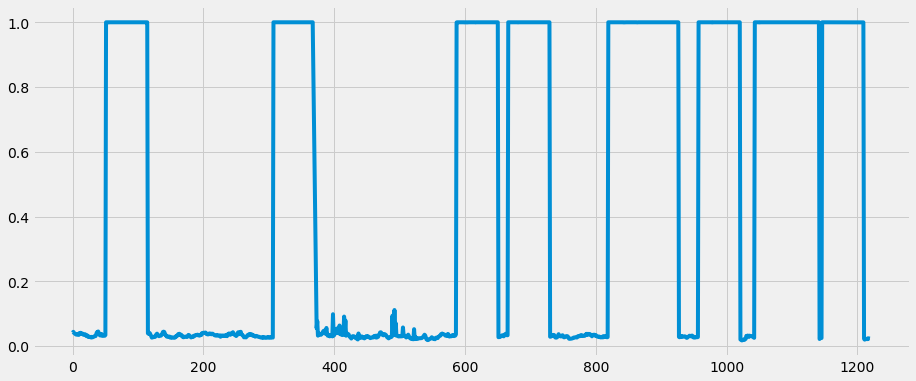

In [7]:
def get_unique_total_values_ratio(df, feature, plot=False, return_result=False):
    df_date_group = df.groupby('time_id').agg({feature: [lambda x: len(x.unique()), 'count']})
    df_date_group.columns.set_levels(['len_unique','count'], level=1,inplace=True)
    df_date_group['unique_count_ratio'] = df_date_group[feature]['len_unique']/df_date_group[feature]['count']
    df_date_group['num_or_cat'] = df_date_group['unique_count_ratio'].apply(lambda x: 1 if x > 0.5 else 0)
    if plot:
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(111)
        plt.plot(df_date_group.index, df_date_group['unique_count_ratio'] , label="Number of unique investments")
    if return_result:
        return df_date_group['num_or_cat']

get_unique_total_values_ratio(train, 'f_1', plot=True)

### f_6

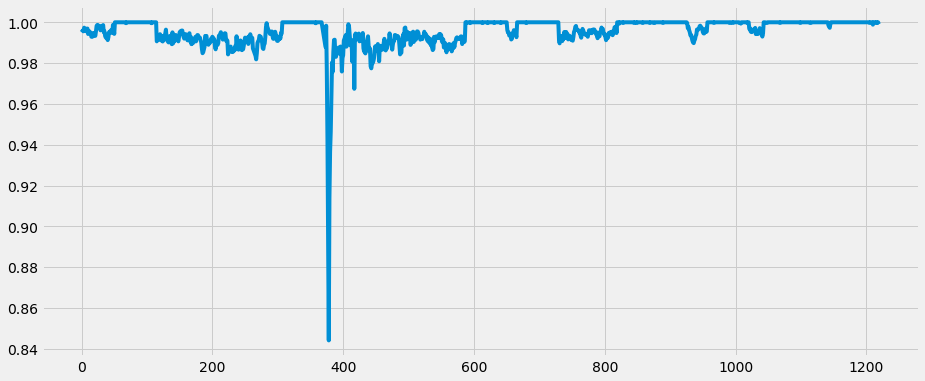

In [8]:
get_unique_total_values_ratio(train, 'f_6', plot=True)

### f_7

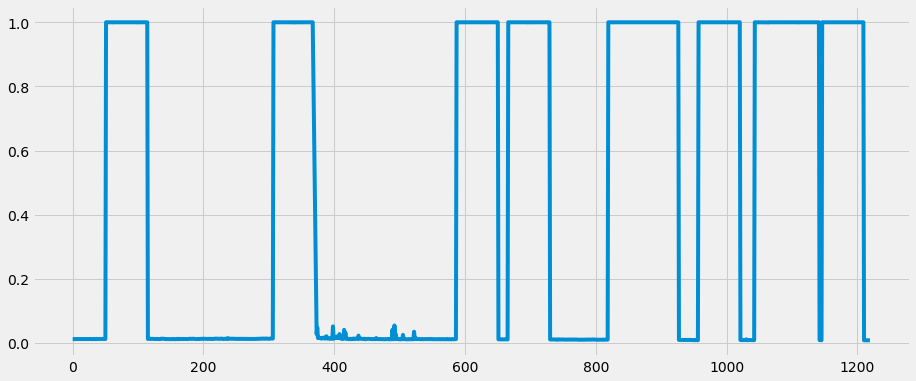

In [9]:
num_or_cat = get_unique_total_values_ratio(train, 'f_7', plot=True, return_result=True)

### Add time_id features

In [10]:
time_id_df = (
    train[["investment_id", "time_id"]]
    .groupby("investment_id")
    .agg(["min", "max", "count", np.ptp])
    .assign(
        time_span=lambda x: x.time_id.ptp,
        time_count=lambda x: x.time_id["count"]
    )
    .drop(columns="ptp", level=1)
    .reset_index()
)
time_id_df.head(6)

investment_id time_id             time_span time_count
                    min   max count                     
0             0     757  1219   461       462        461
1             1       0  1219  1108      1219       1108
2             2       0  1219  1003      1219       1003
3             3      27  1219  1073      1192       1073
4             4     885  1219   316       334        316
5             6       0  1219  1082      1219       1082

### Merge time features with train dataframe

6265

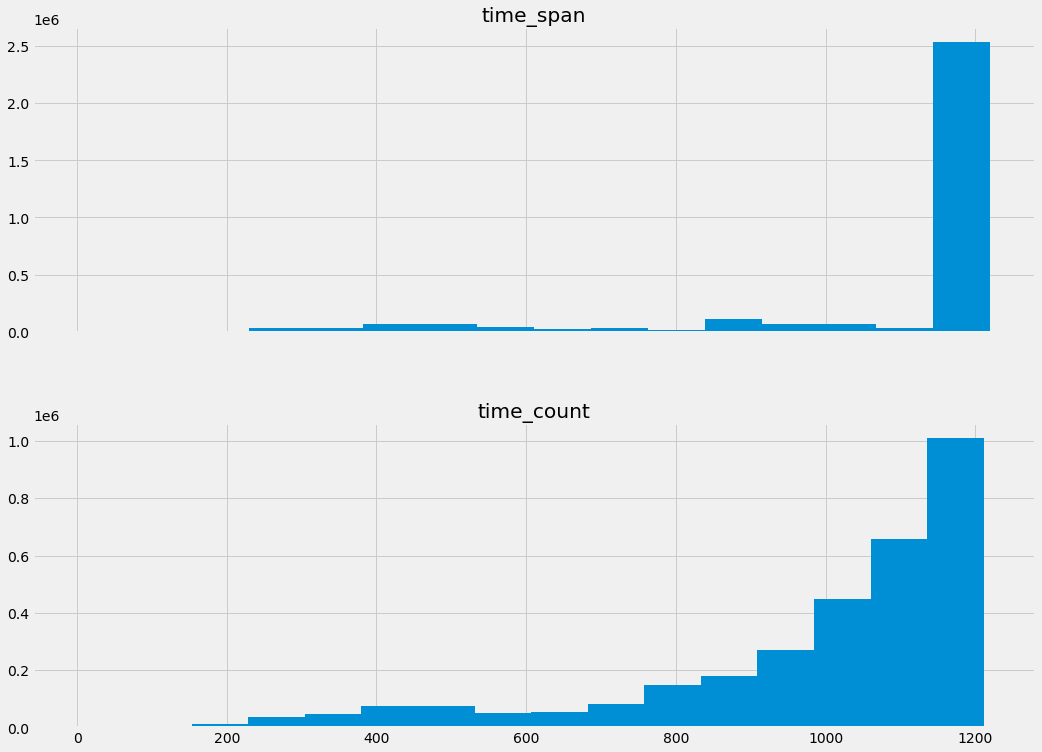

In [11]:
train = train.merge(time_id_df.drop(columns="time_id", level=0).droplevel(level=1, axis=1), on="investment_id", how='left')
train[["time_span", "time_count"]].hist(bins=args.num_bins, figsize=(16,12), sharex=True, layout=(2,1))
max_time_span=time_id_df.time_id["max"].max()
outlier_investments = time_id_df.loc[time_id_df.time_id["count"]<32, "investment_id"].to_list()
del time_id_df
gc.collect()

### Add cluster feature

In [12]:
inv_id_to_cluster = pd.read_pickle('clustered_inv_index.pkl')

train = train.merge(inv_id_to_cluster, how='left', on='investment_id')
train.cluster.fillna(0, inplace=True)

### Add time group feature

In [13]:
train.loc[(train['time_id'] < 910), 'group'] = 0
train.loc[(train['time_id'] >= 910) & (train['time_id'] < 970), 'group'] = 1
train.loc[(train['time_id'] >= 970) & (train['time_id'] < 1030), 'group'] = 2
train.loc[(train['time_id'] >= 1030) & (train['time_id'] < 1090), 'group'] = 3
train.loc[(train['time_id'] >= 1090) & (train['time_id'] < 1150), 'group'] = 4
train.loc[(train['time_id'] >= 1150), 'group'] = 5
train['group'] = train['group'].astype(np.int16)

### Add feature that shows if some features are categorical or numerical for the current time_id

In [14]:
# add numerical/categorical flag
train = train.merge(num_or_cat, how='left', on='time_id')

### Some features are not stationary. Let's make a rank transformation by time_id to make them stationary

In [15]:
train['f_74']  = train[['time_id', 'f_74']].groupby('time_id').rank(pct=True)
train['f_142']  = train[['time_id', 'f_142']].groupby('time_id').rank(pct=True)
train['f_63']  = train[['time_id', 'f_63']].groupby('time_id').rank(pct=True)

### Add total number of investment ids in the current time slot

In [16]:
# investment_id_df = (
#     train[["investment_id", "time_id"]]
#     .groupby("time_id")
#     .agg("count")
#     .rename({"investment_id": "number_of_inv_ids"}, axis=1)
#     .reset_index()
# )
# investment_id_df.head()

# train = train.merge(investment_id_df, how='left', on='time_id')

### Make combinations for some features and drop not necessary features.

In [17]:
cat_features = ['num_or_cat', 'cluster']
num_features = list(train.filter(like="f_").columns)
features = num_features + cat_features

# make feature combinations
combination_features = ["f_231-f_250", "f_118-f_280", "f_155-f_297", "f_25-f_237", "f_179-f_265", "f_119-f_270", "f_71-f_197", "f_21-f_65"]
for f in combination_features:
    f1, f2 = f.split("-")
    train[f] = train[f1] + train[f2]
features += combination_features

# drop unnecessary features
to_drop = ["f_148", "f_72", "f_49", "f_205", "f_228", "f_97", "f_262", "f_258"]
features = list(sorted(set(features).difference(set(to_drop))))

### Reduce memory usage.

In [18]:
%%time

train = reduce_mem_usage(train)
train[["investment_id", "time_id"]] = train[["investment_id", "time_id"]].astype(np.uint16)
train = train.drop(columns=["row_id"] + to_drop)
gc.collect()

features += ["time_id"]
features_backup = features.copy()
len(features)

Memory usage of dataframe is 3870.18 MB
Memory usage after optimization is: 2008.57 MB
Decreased by 48.1%
CPU times: user 39.8 s, sys: 41 s, total: 1min 20s
Wall time: 1min 20s


303

# Train

### Set scoring and training functions

In [19]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# TODO: replace with feval_pearsonr
def feval_rmse(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'rmse', rmse(y_true, y_pred), False

# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', pearsonr(y_true, y_pred)[0], True

# https://www.kaggle.com/gogo827jz/jane-street-supervised-autoencoder-mlp?scriptVersionId=73762661
# weighted average as per Donate et al.'s formula
# https://doi.org/10.1016/j.neucom.2012.02.053
# [0.0625, 0.0625, 0.125, 0.25, 0.5] for 5 fold
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights = w)

def run(info):    
    # hyperparams from: https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization
    params = {
        'learning_rate':0.05,
        "objective": "regression",
        "metric": "rmse",
        'boosting_type': "gbdt",
        'verbosity': -1,
        'n_jobs': -1, 
        'seed': args.seed,
#         'lambda_l1': 0.03627602394442367, 
#         'lambda_l2': 0.43523855951142926, 
#         'num_leaves': 114, 
#         'feature_fraction': 0.9505625064462319, 
#         'bagging_fraction': 0.9785558707339647, 
#         'bagging_freq': 7, 
#         'max_depth': -1, 
#         'max_bin': 501, 
#         'min_data_in_leaf': 374,
        'n_estimators': 1000, 
    }
    
    y = train['target']
    train['preds'] = -1000
    scores = defaultdict(list)
    features_importance= []
    
    def run_single_fold(fold, trn_ind, val_ind):
        train_dataset = lgb.Dataset(train.loc[trn_ind, features], y.loc[trn_ind], categorical_feature=cat_features)
        valid_dataset = lgb.Dataset(train.loc[val_ind, features], y.loc[val_ind], categorical_feature=cat_features)
        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset, valid_dataset], 
            verbose_eval=50,
            early_stopping_rounds=50,
            feval = feval_pearsonr
        )
        joblib.dump(model, f'lgbm_seed{args.seed}_{fold}_{info}.pkl')
        preds = model.predict(train.loc[val_ind, features])
        train.loc[val_ind, "preds"] = preds
        scores["rmse"].append(rmse(y.loc[val_ind], preds))
        scores["pearsonr"].append(pearsonr(y.loc[val_ind], preds)[0])
        fold_importance_df= pd.DataFrame({'feature': features, 'importance': model.feature_importance(), 'fold': fold})
        features_importance.append(fold_importance_df)
        del train_dataset, valid_dataset, model
        gc.collect()
        
    time_thresh = round(train.time_id.max() * 0.9)
    trn_ind, val_ind = train.time_id < time_thresh, train.time_id >= time_thresh
    print(f"train length: {trn_ind.sum()}, valid length: {val_ind.sum()}")
    run_single_fold("single", trn_ind, val_ind)
        
    print(f"lgbm {info} mean rmse: {np.mean(scores['rmse'])}, mean pearsonr: {np.mean(scores['pearsonr'])}")
    if "time" in args.cv_method:
        print(f"lgbm {info} {args.folds} folds weighted mean rmse: {weighted_average(scores['rmse'])}, weighted mean pearsonr: {weighted_average(scores['pearsonr'])}")
    train.filter(regex=r"^(?!f_).*").to_csv(f"preds_{info}.csv", index=False)
    return pd.concat(features_importance, axis=0), scores

### Train with deafault params

train length: 2734026, valid length: 406975
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.913914	training's pearsonr: 0.144081	valid_1's rmse: 0.895549	valid_1's pearsonr: 0.12803
[100]	training's rmse: 0.910333	training's pearsonr: 0.171968	valid_1's rmse: 0.89477	valid_1's pearsonr: 0.130858
[150]	training's rmse: 0.907586	training's pearsonr: 0.191406	valid_1's rmse: 0.894458	valid_1's pearsonr: 0.131878
[200]	training's rmse: 0.905259	training's pearsonr: 0.206348	valid_1's rmse: 0.894127	valid_1's pearsonr: 0.133814
[250]	training's rmse: 0.903123	training's pearsonr: 0.219384	valid_1's rmse: 0.89403	valid_1's pearsonr: 0.133834
Early stopping, best iteration is:
[209]	training's rmse: 0.904863	training's pearsonr: 0.208793	valid_1's rmse: 0.894025	valid_1's pearsonr: 0.134574
lgbm  mean rmse: 0.894025431283108, mean pearsonr: 0.13457408075998248
lgbm  single 5 folds mean rmse: 0.8940, mean pearsonr: 0.1346, mean pearsonr by time_id: 0.1336


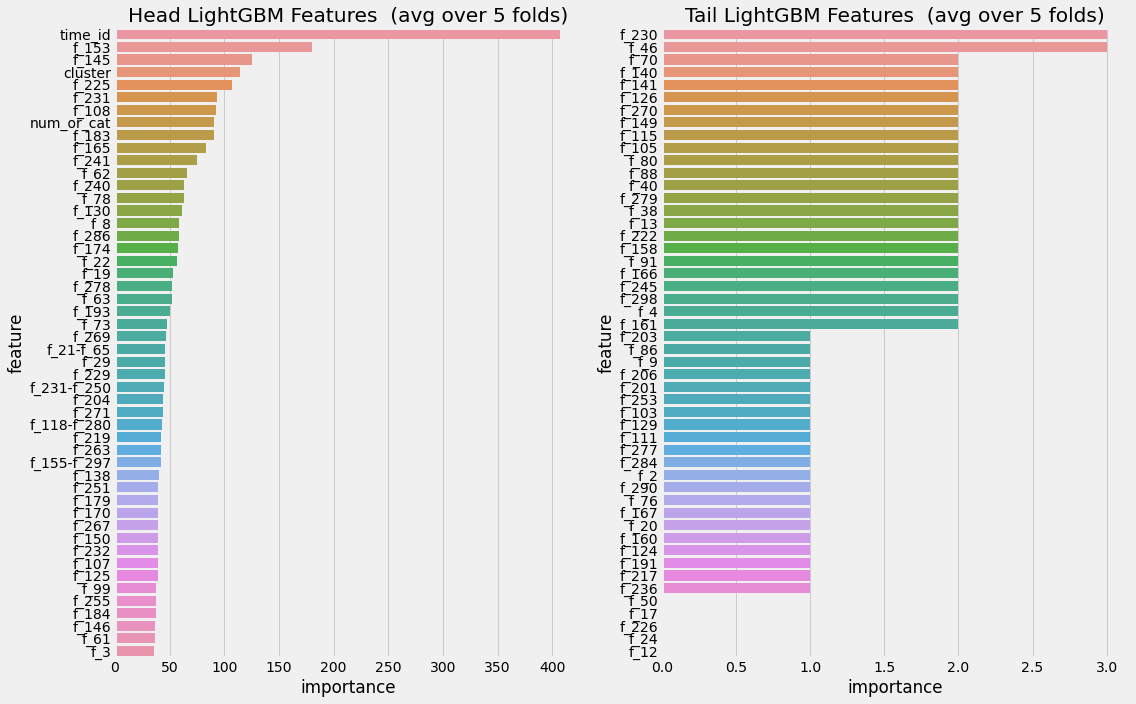

CPU times: user 30min 39s, sys: 2min 4s, total: 32min 43s
Wall time: 3min 6s


In [20]:
%%time

if args.train:
    info = ""
    features_importance, scores = run(info=info)
    df = train[["target", "preds", "time_id"]].query("preds!=-1000")
    score = df.groupby("time_id").apply(lambda x: pearsonr(x.target, x.preds)[0]).mean()
    print(f"lgbm {info} {args.cv_method} {args.folds} folds mean rmse: {rmse(df.target, df.preds):.4f}, mean pearsonr: {pearsonr(df.target, df.preds)[0]:.4f}, mean pearsonr by time_id: {score:.4f}")

    features_importance.to_csv(f"features_importance_{info}.csv", index=False)

    plt.figure(figsize=(16, 10))
    plt.subplot(1,2,1)
    sns.barplot(x="importance", y="feature", data=features_importance.sort_values('importance', ascending=False).head(50))
    plt.title(f'Head LightGBM Features {info} (avg over {args.folds} folds)')
    plt.subplot(1,2,2)
    sns.barplot(x="importance", y="feature", data=features_importance.sort_values('importance', ascending=False).tail(50))
    plt.title(f'Tail LightGBM Features {info} (avg over {args.folds} folds)')
    plt.tight_layout()
    plt.show()
    del df

# del train
# gc.collect()

In [21]:
features_importance.sort_values('importance', ascending=False)

,feature,importance,fold
302,time_id,407,single
63,f_153,180,single
55,f_145,125,single
0,cluster,114,single
145,f_225,107,single
...,...,...,...
248,f_50,0,single
82,f_17,0,single
146,f_226,0,single
161,f_24,0,single


### Default train result (TR)

In [21]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913495	training's pearsonr: 0.142616	valid_1's rmse: 0.893252	valid_1's pearsonr: 0.120425
# [100]	training's rmse: 0.910131	training's pearsonr: 0.168593	valid_1's rmse: 0.892492	valid_1's pearsonr: 0.124259
# [150]	training's rmse: 0.907482	training's pearsonr: 0.187509	valid_1's rmse: 0.892142	valid_1's pearsonr: 0.126149
# [200]	training's rmse: 0.905157	training's pearsonr: 0.202793	valid_1's rmse: 0.891841	valid_1's pearsonr: 0.128066
# [250]	training's rmse: 0.903156	training's pearsonr: 0.215191	valid_1's rmse: 0.891582	valid_1's pearsonr: 0.12995
# [300]	training's rmse: 0.901242	training's pearsonr: 0.226596	valid_1's rmse: 0.891391	valid_1's pearsonr: 0.13139
# [350]	training's rmse: 0.899505	training's pearsonr: 0.236714	valid_1's rmse: 0.89131	valid_1's pearsonr: 0.131979
# [400]	training's rmse: 0.897919	training's pearsonr: 0.245771	valid_1's rmse: 0.89125	valid_1's pearsonr: 0.132446
# [450]	training's rmse: 0.896436	training's pearsonr: 0.253974	valid_1's rmse: 0.891155	valid_1's pearsonr: 0.133229
# [500]	training's rmse: 0.895023	training's pearsonr: 0.261692	valid_1's rmse: 0.891156	valid_1's pearsonr: 0.133253
# Early stopping, best iteration is:
# [481]	training's rmse: 0.895565	training's pearsonr: 0.258794	valid_1's rmse: 0.891124	valid_1's pearsonr: 0.1335
# lgbm  mean rmse: 0.8911238146098072, mean pearsonr: 0.13350046963244608
# lgbm  single 5 folds mean rmse: 0.8911, mean pearsonr: 0.1335, mean pearsonr by time_id: 0.1323

### TR With cluster

In [22]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913461	training's pearsonr: 0.143116	valid_1's rmse: 0.893182	valid_1's pearsonr: 0.121547
# [100]	training's rmse: 0.910053	training's pearsonr: 0.169428	valid_1's rmse: 0.892459	valid_1's pearsonr: 0.124652
# [150]	training's rmse: 0.907379	training's pearsonr: 0.188418	valid_1's rmse: 0.892083	valid_1's pearsonr: 0.126663
# [200]	training's rmse: 0.90512	training's pearsonr: 0.203306	valid_1's rmse: 0.891803	valid_1's pearsonr: 0.128458
# [250]	training's rmse: 0.902993	training's pearsonr: 0.216404	valid_1's rmse: 0.891463	valid_1's pearsonr: 0.130997
# [300]	training's rmse: 0.901071	training's pearsonr: 0.227823	valid_1's rmse: 0.891351	valid_1's pearsonr: 0.131751
# [350]	training's rmse: 0.899276	training's pearsonr: 0.23814	valid_1's rmse: 0.891276	valid_1's pearsonr: 0.132278
# [400]	training's rmse: 0.897597	training's pearsonr: 0.247602	valid_1's rmse: 0.89123	valid_1's pearsonr: 0.132624
# [450]	training's rmse: 0.896139	training's pearsonr: 0.255601	valid_1's rmse: 0.891209	valid_1's pearsonr: 0.132796
# [500]	training's rmse: 0.89471	training's pearsonr: 0.263177	valid_1's rmse: 0.891133	valid_1's pearsonr: 0.13344
# [550]	training's rmse: 0.893372	training's pearsonr: 0.270296	valid_1's rmse: 0.891164	valid_1's pearsonr: 0.133233
# Early stopping, best iteration is:
# [512]	training's rmse: 0.894384	training's pearsonr: 0.264875	valid_1's rmse: 0.891105	valid_1's pearsonr: 0.133674
# lgbm  mean rmse: 0.8911047624005334, mean pearsonr: 0.1336744916036186
# lgbm  single 5 folds mean rmse: 0.8911, mean pearsonr: 0.1337, mean pearsonr by time_id: 0.1326

### TR without feature drop 

In [ ]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913463	training's pearsonr: 0.143092	valid_1's rmse: 0.893183	valid_1's pearsonr: 0.121544
# [100]	training's rmse: 0.910058	training's pearsonr: 0.169473	valid_1's rmse: 0.892463	valid_1's pearsonr: 0.124563
# [150]	training's rmse: 0.907387	training's pearsonr: 0.188442	valid_1's rmse: 0.892164	valid_1's pearsonr: 0.125814
# [200]	training's rmse: 0.905047	training's pearsonr: 0.203661	valid_1's rmse: 0.891804	valid_1's pearsonr: 0.128382
# [250]	training's rmse: 0.90294	training's pearsonr: 0.216912	valid_1's rmse: 0.89164	valid_1's pearsonr: 0.129429
# [300]	training's rmse: 0.901025	training's pearsonr: 0.22821	valid_1's rmse: 0.891533	valid_1's pearsonr: 0.130148
# [350]	training's rmse: 0.89927	training's pearsonr: 0.238442	valid_1's rmse: 0.891468	valid_1's pearsonr: 0.130622
# [400]	training's rmse: 0.897588	training's pearsonr: 0.247917	valid_1's rmse: 0.891375	valid_1's pearsonr: 0.131394
# [450]	training's rmse: 0.896087	training's pearsonr: 0.256123	valid_1's rmse: 0.891288	valid_1's pearsonr: 0.132134
# Early stopping, best iteration is:
# [445]	training's rmse: 0.896249	training's pearsonr: 0.25525	valid_1's rmse: 0.891279	valid_1's pearsonr: 0.132202
# lgbm  mean rmse: 0.8912791632488314, mean pearsonr: 0.13220228428357278
# lgbm  single 5 folds mean rmse: 0.8913, mean pearsonr: 0.1322, mean pearsonr by time_id: 0.1312

### TR without feature combination

In [ ]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.91336	training's pearsonr: 0.145758	valid_1's rmse: 0.893211	valid_1's pearsonr: 0.122407
# [100]	training's rmse: 0.909936	training's pearsonr: 0.171172	valid_1's rmse: 0.892531	valid_1's pearsonr: 0.124115
# [150]	training's rmse: 0.907281	training's pearsonr: 0.189591	valid_1's rmse: 0.892219	valid_1's pearsonr: 0.125415
# [200]	training's rmse: 0.904959	training's pearsonr: 0.204902	valid_1's rmse: 0.891898	valid_1's pearsonr: 0.127578
# [250]	training's rmse: 0.902822	training's pearsonr: 0.218144	valid_1's rmse: 0.891634	valid_1's pearsonr: 0.129504
# [300]	training's rmse: 0.900887	training's pearsonr: 0.229376	valid_1's rmse: 0.891523	valid_1's pearsonr: 0.130239
# Early stopping, best iteration is:
# [281]	training's rmse: 0.901628	training's pearsonr: 0.225115	valid_1's rmse: 0.89151	valid_1's pearsonr: 0.130427
# lgbm  mean rmse: 0.8915104886199198, mean pearsonr: 0.1304268181221421
# lgbm  single 5 folds mean rmse: 0.8915, mean pearsonr: 0.1304, mean pearsonr by time_id: 0.1295

### TR with time count

In [ ]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913441	training's pearsonr: 0.143483	valid_1's rmse: 0.893202	valid_1's pearsonr: 0.121082
# [100]	training's rmse: 0.910065	training's pearsonr: 0.169299	valid_1's rmse: 0.892583	valid_1's pearsonr: 0.123181
# [150]	training's rmse: 0.907355	training's pearsonr: 0.188754	valid_1's rmse: 0.892366	valid_1's pearsonr: 0.123739
# [200]	training's rmse: 0.905042	training's pearsonr: 0.203778	valid_1's rmse: 0.892034	valid_1's pearsonr: 0.126127
# [250]	training's rmse: 0.902981	training's pearsonr: 0.216456	valid_1's rmse: 0.891919	valid_1's pearsonr: 0.126851
# [300]	training's rmse: 0.901086	training's pearsonr: 0.227754	valid_1's rmse: 0.891825	valid_1's pearsonr: 0.127594
# [350]	training's rmse: 0.899268	training's pearsonr: 0.238216	valid_1's rmse: 0.891629	valid_1's pearsonr: 0.129302
# [400]	training's rmse: 0.897667	training's pearsonr: 0.247263	valid_1's rmse: 0.891522	valid_1's pearsonr: 0.13023
# Early stopping, best iteration is:
# [396]	training's rmse: 0.897797	training's pearsonr: 0.246568	valid_1's rmse: 0.891511	valid_1's pearsonr: 0.13032
# lgbm  mean rmse: 0.8915109580151447, mean pearsonr: 0.13031984284816603
# lgbm  single 5 folds mean rmse: 0.8915, mean pearsonr: 0.1303, mean pearsonr by time_id: 0.1295

### TR without mem reduce

In [ ]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913425	training's pearsonr: 0.143582	valid_1's rmse: 0.89312	valid_1's pearsonr: 0.122454
# [100]	training's rmse: 0.90995	training's pearsonr: 0.170668	valid_1's rmse: 0.892519	valid_1's pearsonr: 0.124243
# [150]	training's rmse: 0.907212	training's pearsonr: 0.19006	valid_1's rmse: 0.89218	valid_1's pearsonr: 0.125886
# [200]	training's rmse: 0.904902	training's pearsonr: 0.205033	valid_1's rmse: 0.891828	valid_1's pearsonr: 0.128288
# [250]	training's rmse: 0.9028	training's pearsonr: 0.217729	valid_1's rmse: 0.891673	valid_1's pearsonr: 0.129193
# [300]	training's rmse: 0.900943	training's pearsonr: 0.228556	valid_1's rmse: 0.89159	valid_1's pearsonr: 0.129686
# [350]	training's rmse: 0.899083	training's pearsonr: 0.239187	valid_1's rmse: 0.891524	valid_1's pearsonr: 0.130165
# [400]	training's rmse: 0.897405	training's pearsonr: 0.248648	valid_1's rmse: 0.891466	valid_1's pearsonr: 0.130633
# Early stopping, best iteration is:
# [387]	training's rmse: 0.897875	training's pearsonr: 0.2461	valid_1's rmse: 0.891454	valid_1's pearsonr: 0.130737
# lgbm  mean rmse: 0.8914535578326841, mean pearsonr: 0.13073718524285932
# lgbm  single 5 folds mean rmse: 0.8915, mean pearsonr: 0.1307, mean pearsonr by time_id: 0.1299

### TR with stationary features

In [ ]:
# train length: 2730228, valid length: 404480
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913502	training's pearsonr: 0.142546	valid_1's rmse: 0.893222	valid_1's pearsonr: 0.121083
# [100]	training's rmse: 0.910143	training's pearsonr: 0.168708	valid_1's rmse: 0.892512	valid_1's pearsonr: 0.124204
# [150]	training's rmse: 0.907488	training's pearsonr: 0.187753	valid_1's rmse: 0.892059	valid_1's pearsonr: 0.127068
# [200]	training's rmse: 0.905243	training's pearsonr: 0.202267	valid_1's rmse: 0.891762	valid_1's pearsonr: 0.128852
# [250]	training's rmse: 0.903177	training's pearsonr: 0.214916	valid_1's rmse: 0.891585	valid_1's pearsonr: 0.129919
# [300]	training's rmse: 0.901234	training's pearsonr: 0.226851	valid_1's rmse: 0.891419	valid_1's pearsonr: 0.131154
# [350]	training's rmse: 0.899522	training's pearsonr: 0.236617	valid_1's rmse: 0.891308	valid_1's pearsonr: 0.131992
# [400]	training's rmse: 0.897945	training's pearsonr: 0.245518	valid_1's rmse: 0.89119	valid_1's pearsonr: 0.132952
# [450]	training's rmse: 0.896443	training's pearsonr: 0.253827	valid_1's rmse: 0.891095	valid_1's pearsonr: 0.133763
# [500]	training's rmse: 0.895127	training's pearsonr: 0.261148	valid_1's rmse: 0.891043	valid_1's pearsonr: 0.134213
# [550]	training's rmse: 0.893769	training's pearsonr: 0.268384	valid_1's rmse: 0.891066	valid_1's pearsonr: 0.134085
# [600]	training's rmse: 0.892506	training's pearsonr: 0.274995	valid_1's rmse: 0.891023	valid_1's pearsonr: 0.134475
# [650]	training's rmse: 0.891267	training's pearsonr: 0.281475	valid_1's rmse: 0.891024	valid_1's pearsonr: 0.134536
# [700]	training's rmse: 0.890041	training's pearsonr: 0.287779	valid_1's rmse: 0.89101	valid_1's pearsonr: 0.134713
# [750]	training's rmse: 0.888888	training's pearsonr: 0.293626	valid_1's rmse: 0.891043	valid_1's pearsonr: 0.134528
# Early stopping, best iteration is:
# [724]	training's rmse: 0.889471	training's pearsonr: 0.290639	valid_1's rmse: 0.890985	valid_1's pearsonr: 0.134954
# lgbm  mean rmse: 0.8909846204281174, mean pearsonr: 0.13495411733280074
# lgbm  single 5 folds mean rmse: 0.8910, mean pearsonr: 0.1350, mean pearsonr by time_id: 0.1342

### TR with time_id feature

In [ ]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913294	training's pearsonr: 0.145056	valid_1's rmse: 0.892551	valid_1's pearsonr: 0.129345
# [100]	training's rmse: 0.909748	training's pearsonr: 0.17247	valid_1's rmse: 0.89164	valid_1's pearsonr: 0.133348
# [150]	training's rmse: 0.906965	training's pearsonr: 0.192072	valid_1's rmse: 0.891193	valid_1's pearsonr: 0.135453
# [200]	training's rmse: 0.904643	training's pearsonr: 0.206866	valid_1's rmse: 0.8911	valid_1's pearsonr: 0.134688
# Early stopping, best iteration is:
# [153]	training's rmse: 0.906805	training's pearsonr: 0.193178	valid_1's rmse: 0.891174	valid_1's pearsonr: 0.135576
# lgbm  mean rmse: 0.8911738676667103, mean pearsonr: 0.13557597447557707
# lgbm  single 5 folds mean rmse: 0.8912, mean pearsonr: 0.1356, mean pearsonr by time_id: 0.1343

### TR with number of unique investment_ids for each time slot (severe overfitting)

In [ ]:
# train length: 2730228, valid length: 404480
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.903825	training's pearsonr: 0.225623	valid_1's rmse: 0.894297	valid_1's pearsonr: 0.110317
# [100]	training's rmse: 0.894679	training's pearsonr: 0.267537	valid_1's rmse: 0.893818	valid_1's pearsonr: 0.111905
# [150]	training's rmse: 0.888101	training's pearsonr: 0.292933	valid_1's rmse: 0.893554	valid_1's pearsonr: 0.114139
# [200]	training's rmse: 0.88281	training's pearsonr: 0.311474	valid_1's rmse: 0.893473	valid_1's pearsonr: 0.115453
# [250]	training's rmse: 0.878436	training's pearsonr: 0.325472	valid_1's rmse: 0.893476	valid_1's pearsonr: 0.116625
# Early stopping, best iteration is:
# [208]	training's rmse: 0.882118	training's pearsonr: 0.31384	valid_1's rmse: 0.893413	valid_1's pearsonr: 0.116192
# lgbm  mean rmse: 0.8934127327366368, mean pearsonr: 0.11619159179160031
# lgbm  single 5 folds mean rmse: 0.8934, mean pearsonr: 0.1162, mean pearsonr by time_id: 0.1165

### TR with dropping of turbulence period

In [ ]:
# train length: 2158260, valid length: 404480
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.918916	training's pearsonr: 0.142518	valid_1's rmse: 0.892317	valid_1's pearsonr: 0.131316
# [100]	training's rmse: 0.915298	training's pearsonr: 0.171884	valid_1's rmse: 0.891521	valid_1's pearsonr: 0.134
# [150]	training's rmse: 0.912327	training's pearsonr: 0.193654	valid_1's rmse: 0.891252	valid_1's pearsonr: 0.13409
# Early stopping, best iteration is:
# [113]	training's rmse: 0.914491	training's pearsonr: 0.178089	valid_1's rmse: 0.891358	valid_1's pearsonr: 0.134786
# lgbm  mean rmse: 0.8913579954765509, mean pearsonr: 0.13478587216152654
# lgbm  single 5 folds mean rmse: 0.8914, mean pearsonr: 0.1348, mean pearsonr by time_id: 0.1341

### TR after dropping 1% of outliers

In [ ]:
train length: 2721716, valid length: 400936
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.912026	training's pearsonr: 0.144362	valid_1's rmse: 0.889594	valid_1's pearsonr: 0.126832
[100]	training's rmse: 0.908515	training's pearsonr: 0.171711	valid_1's rmse: 0.88873	valid_1's pearsonr: 0.130496
[150]	training's rmse: 0.905757	training's pearsonr: 0.191199	valid_1's rmse: 0.888274	valid_1's pearsonr: 0.132442
[200]	training's rmse: 0.903413	training's pearsonr: 0.206336	valid_1's rmse: 0.888028	valid_1's pearsonr: 0.133714
[250]	training's rmse: 0.901297	training's pearsonr: 0.219354	valid_1's rmse: 0.888142	valid_1's pearsonr: 0.132059
Early stopping, best iteration is:
[204]	training's rmse: 0.903244	training's pearsonr: 0.207351	valid_1's rmse: 0.887986	valid_1's pearsonr: 0.133997
lgbm  mean rmse: 0.8879864773504915, mean pearsonr: 0.13399666820557865
lgbm  single 5 folds mean rmse: 0.8880, mean pearsonr: 0.1340, mean pearsonr by time_id: 0.1327

### TR after dropping 0.1% of outliers

# Optimize LGBM with Optuna

In [ ]:
import optuna
import warnings
warnings.filterwarnings("ignore", module="lightgbm")
from sklearn.metrics import mean_squared_error

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    # https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
    def feval_pearsonr(y_pred, lgb_train):
        y_true = lgb_train.get_label()
        return 'pearsonr', pearsonr(y_true, y_pred)[0], True
    
    time_thresh = round(train.time_id.max() * 0.9)
    trn_ind, val_ind = train.time_id < time_thresh, train.time_id >= time_thresh
    
    X_train, y_train = train.loc[trn_ind, features], train.loc[trn_ind, 'target']
    X_val, y_val = train.loc[val_ind, features], train.loc[val_ind, 'target']
    
    dtrain = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
    dvalid = lgb.Dataset(X_val, y_val, categorical_feature=cat_features)

    param = {
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'objective': 'regression',
        'metric': 'rmse',
        'seed': args.seed,
        'verbosity': 0,
        'boosting_type': 'gbdt', # other options: rf, dart, goss
        'force_col_wise': False, # Use only with CPU devices
       
        'subsample_for_bin': 300000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200),      
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 1e-1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # Max number of leaves in one tree
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be 
                                                           # bucketed in. small number of bins may reduce training 
                                                           # accuracy but may deal with overfitting
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0), # Randomly select a subset of features 
                                                                               # if feature_fraction < 1.0
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0), # Randomly select part of data without 
                                                                               # resampling if bagging_fraction < 1.0
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7), # Perform bagging at every k iteration
        'min_data_in_leaf': trial.suggest_int('min_child_samples', 5, 100), # Minimal number of data in one leaf
                                                                            # aliases: min_child_samples, 
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 1e-1), # Stop trying to split 
                                                                                               # leave if sum of it's
                                                                                               # hessian less than k
        'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0), # this can reduce the effect of noises in 
                                                                      # categorical features, especially for 
                                                                      # categories with few data
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'pearsonr', valid_name='valid_1')
    gbm = lgb.train(
        param, 
        train_set = dtrain, 
        valid_sets = [dtrain, dvalid], 
        verbose_eval=100, 
        feval=feval_pearsonr,
        callbacks=[pruning_callback]
    )

    y_pred = gbm.predict(X_val)
    corr = pearsonr(y_val, y_pred)[0]
    return corr


if args.optimize is True:
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
    )
    study.optimize(objective, timeout=7*1800)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    
    

# Stacking best LGBM models

### Get best parameters

In [ ]:
if args.train_l2 is True:
    # lgb_params = study.trials_dataframe()
    # lgb_params.to_pickle('LGBM_Optuna_params.pkl')
    lgb_params = pd.read_pickle('LGBM_Optuna_params.pkl').sort_values('value', ascending=False).head(11)

    param_cols = [c for c in lgb_params.columns if c.startswith('params_')]
    lgb_params = lgb_params[param_cols]

    best_params = list()

    for idx, row in lgb_params.iterrows():
        row_dict = {k[7:]: v for k, v in row.items()}
        row_dict['device'] = 'gpu'
        row_dict['gpu_platform_id'] = 0
        row_dict['gpu_device_id'] = 0
        row_dict['verbosity'] = 0
        row_dict['max_bin'] = int(row_dict['max_bin'])
        row_dict['bagging_freq'] = int(row_dict['bagging_freq'])
        row_dict['min_child_samples'] = int(row_dict['min_child_samples'])
        row_dict['n_estimators'] = int(row_dict['n_estimators'])
        row_dict['num_leaves'] = int(row_dict['num_leaves'])
        best_params.append(row_dict)

### Create metafeatures for the train set

In [ ]:
if args.train_l2 is True:
    groups_level2 = [1, 2, 3, 4, 5]

    # That is how we get target for the 2nd level dataset
    y_train_level2 = train.loc[train.group.isin(groups_level2), 'target']

    # Create 1st level feature matrix
    X_train, y_train = train[features], train['target']
    
    # And here we create 2nd level feature matrix, init it with zeros first
    X_train_level2 = np.zeros([y_train_level2.shape[0], len(best_params)+1])
    X_train_level2[:, len(best_params)] = y_train_level2

    meta_index_begin = 0
    meta_index_end = 0

    # Now fill `X_train_level2` with metafeatures
    for current_group in tqdm(groups_level2):
        # split data
        train_index = X_train.loc[train.group <  current_group].index
        test_index  = X_train.loc[train.group == current_group].index

        X_train_l2 = X_train.loc[train_index, :]
        X_test_l2 =  X_train.loc[test_index, :]

        y_train_l2 = y_train[train_index]
        y_test_l2 =  y_train[test_index]

        meta_index_end += y_test_l2.shape[0]

        print(f"===================== time group: {current_group} =====================")
        
        # predict metafeatures for each of LGBM regressors
        for i, params in enumerate(tqdm(best_params)):
            print(f"===================== model: {i} =====================")
            train_dataset = lgb.Dataset(X_train_l2, y_train_l2, categorical_feature=cat_features)
            model = lgb.train(
                params,
                train_set = train_dataset, 
                valid_sets = [train_dataset], 
                verbose_eval=100,
                feval = feval_pearsonr
            )
#             joblib.dump(model, f'lgbr_{i+1}.pkl')
            
            pred = model.predict(X_test_l2)
            X_train_level2[meta_index_begin:meta_index_end, i] = pred

            del train_dataset, model, pred
            gc.collect()

        meta_index_begin = meta_index_end

    X_train_level2 = pd.DataFrame(X_train_level2, columns=[f'lgbr_{i+1}' for i in range(len(best_params))]+['target'])
    X_train_level2.to_pickle('LGBM_X_train_level2.pkl')
    
    # train every LGB model on the full dataset and save it
    for i, params in enumerate(tqdm(best_params)):
        print(f"===================== model: {i} =====================")
        train_dataset = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset], 
            verbose_eval=100,
            feval = feval_pearsonr
        )
        joblib.dump(model, f'lgbr_{i+1}.pkl')

    del X_train, y_train
    gc.collect()

# Fit LinearRegression for the second layer

In [ ]:
if args.train_l2 is True:
    X_train_level2 = joblib.load('../input/ubiquant-lgbm-models/LGBM_X_train_level2.pkl')

    X = X_train_level2.iloc[:, [i for i in range(5)]]
    y = X_train_level2['target']

    lr = LinearRegression()
    lr.fit(X, y)

    joblib.dump(lr, 'lr.pkl')

# Inference

In [ ]:
import ubiquant

if.args.inference:
    env = ubiquant.make_env()  
    iter_test = env.iter_test()

    lr_model = joblib.load('./lr.pkl')
    lgbr_models = list(map(joblib.load, sorted(Path("../input/ubiquant-lgbm-models").glob("lgbr_*.pkl"))))

    # https://www.kaggle.com/c/ubiquant-market-prediction/discussion/305353 
    # When making predictions check if the investment_id was in the train set
    for (test_df, sample_prediction_df) in iter_test:
        # get feature combinations
        for f in combination_features:
            f1, f2 = f.split("-")
            test_df[f] = test_df[f1] + test_df[f2]

    #     test_df["time_id"] = test_df.row_id.str.split("_", expand=True)[1].astype(np.uint16) # extract time_id from row_id
        unqiues = len(test_df['f_7'].unique())
        if unqiues/len(test_df) > 0.5:
            test_df['num_or_cat'] = 0
        else:
            test_df['num_or_cat'] = 1

        test_df["preds"] = lr_model.predict(np.stack([model.predict(test_df[features_backup]) for model in lgbr_models[:5]], axis=1))
        sample_prediction_df['target'] = test_df["preds"]
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

# Further ideas

- drop first time ids from dataset 
- drop turbulence time from dataset
- standard scale?
- add total number of investment ids in previous time period
- target EMA
- try cut the outliers with different thresholds or don't cut them at all


- try LAMA


- try counting time slots for each investment_id
- LGBM Imputation


- try custom loss function (for DNN)

# What works for LGBM CV

- define if feature is numerical of categorical at this time period (num_or_cat)
- clipping of target (at 0.5% min/max)